# Multiplicity determination with Calibr

Note: Uses the R3BRoot NeuLAND module. As this module is compiled with ROOT, it is available in Python by `import ROOT` if the environment variables are set.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import ROOT

sys.path.append("..")
from helpers import filename_for

Welcome to JupyROOT 6.16/00


## Example Fit / Calibration
We can run the full calibration from python, with some amount of yucky syntax

In [2]:
label = "nPN"
max_neutrons = 4
num_dp = 30

In [3]:
def calibrate_calibr(infiles, outfile, max_neutrons, image):
    cal = ROOT.Neuland.Neutron2DCalibr(max_neutrons)
    for file in infiles:
        print(f"Processing {file} ...", flush=True)
        cal.AddClusterFile(os.fspath(file))
    vslope = ROOT.std.vector("double")()
    vslope += [0.04, 0.001, 0.001, 10]
    vdistance = ROOT.std.vector("double")()
    vdistance += [10, 0.5, 6, 60]
    vdist_off = ROOT.std.vector("double")()
    vdist_off += [3, 0.5, 3, 6]
    cal.Optimize(vslope, vdistance, vdist_off)
    cal.WriteParameterFile(outfile)
    cal.Draw(image)
    # del cal

In [4]:
infiles = [
    filename_for(15, num_dp, 600, 500, neutrons, "inclxx", subrun, "digi.root")
    for subrun in range(20)
    for neutrons in range(1, max_neutrons + 1)
]                    
    
outfile = f"out/600AMeV_30dp_{max_neutrons}n.ncut.root"
image = f"out/600AMeV_30dp_{max_neutrons}n.png"

if os.path.exists(outfile):
    os.remove(outfile)

calibrate_calibr(infiles, outfile, max_neutrons, image)

Processing /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/trifeature/../data/15m_30dp_600AMeV_500keV_1n.inclxx.00.digi.root ...
Processing /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/trifeature/../data/15m_30dp_600AMeV_500keV_2n.inclxx.00.digi.root ...
Processing /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/trifeature/../data/15m_30dp_600AMeV_500keV_3n.inclxx.00.digi.root ...
Processing /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/trifeature/../data/15m_30dp_600AMeV_500keV_4n.inclxx.00.digi.root ...
Processing /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/trifeature/../data/15m_30dp_600AMeV_500keV_1n.inclxx.01.digi.root ...
Processing /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/trifeature/../data/15m_30dp_600AMeV_500keV_2n.inclxx.01.digi.root ...
Processing /srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/trifeature/../data/15m_30dp

Info in <TCanvas::Print>: png file out/600AMeV_30dp_4n.png has been created


## Example Prediction

In [5]:
cutf = ROOT.TFile.Open(f"out/600AMeV_{num_dp}dp_{max_neutrons}n.ncut.root")
para = cutf.Get("R3BNeulandNeutron2DPar")

dfs = [
    pd.read_pickle(filename_for(15, num_dp, 600, 500, neutrons, "inclxx", subrun, "trifeature.pkl"))
    for subrun in range(20)
    for neutrons in range(1, max_neutrons + 1)
]
testdata = pd.concat(dfs, ignore_index=True)

y_true = testdata[[label]].values.ravel()
y_pred = np.array([para.GetNeutronMultiplicity(row["Edep"], row["nClus"]) for _, row in testdata.iterrows()])

print(list(zip(y_true, y_pred))[0:50])

[(1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 2), (1, 2), (1, 2), (1, 0), (1, 0), (1, 1), (1, 0), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1)]


In [6]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1), normalize="true")
print(cmrel)

/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.6864600000000001
[[     0      0      0      0      0]
 [ 19117 165698  15083     58     44]
 [  1481  35841 135784  26776    118]
 [   105   4879  48392 116700  29924]
 [     7    563   9857  58587 130986]]
[[0.    0.    0.    0.    0.   ]
 [0.096 0.828 0.075 0.    0.   ]
 [0.007 0.179 0.679 0.134 0.001]
 [0.001 0.024 0.242 0.584 0.15 ]
 [0.    0.003 0.049 0.293 0.655]]


Text(69.0, 0.5, 'True')

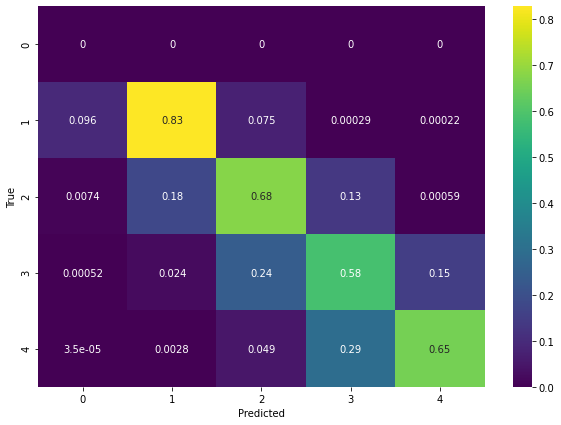

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")